In [ ]:
import importlib.util
import sys
import os
from google.colab import drive
drive.mount('/content/gdrive')

file = '/content/gdrive/My Drive/Face_Recognition2/'
sys.path.append(os.path.abspath(file))

import utils


Mounted at /content/gdrive


In [ ]:
import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

In [ ]:

from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.models import Model
from keras import backend as K

import utils
from utils import LRN2D

def create_model():
    myInput = Input(shape=(96, 96, 3))

    x = ZeroPadding2D(padding=(3, 3), input_shape=(96, 96, 3))(myInput)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn1')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)
    x = Lambda(LRN2D, name='lrn_1')(x)
    x = Conv2D(64, (1, 1), name='conv2')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn2')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(192, (3, 3), name='conv3')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn3')(x)
    x = Activation('relu')(x)
    x = Lambda(LRN2D, name='lrn_2')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)

    # Inception3a
    inception_3a_3x3 = Conv2D(96, (1, 1), name='inception_3a_3x3_conv1')(x)
    inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn1')(inception_3a_3x3)
    inception_3a_3x3 = Activation('relu')(inception_3a_3x3)
    inception_3a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3)
    inception_3a_3x3 = Conv2D(128, (3, 3), name='inception_3a_3x3_conv2')(inception_3a_3x3)
    inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn2')(inception_3a_3x3)
    inception_3a_3x3 = Activation('relu')(inception_3a_3x3)

    inception_3a_5x5 = Conv2D(16, (1, 1), name='inception_3a_5x5_conv1')(x)
    inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn1')(inception_3a_5x5)
    inception_3a_5x5 = Activation('relu')(inception_3a_5x5)
    inception_3a_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5)
    inception_3a_5x5 = Conv2D(32, (5, 5), name='inception_3a_5x5_conv2')(inception_3a_5x5)
    inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn2')(inception_3a_5x5)
    inception_3a_5x5 = Activation('relu')(inception_3a_5x5)

    inception_3a_pool = MaxPooling2D(pool_size=3, strides=2)(x)
    inception_3a_pool = Conv2D(32, (1, 1), name='inception_3a_pool_conv')(inception_3a_pool)
    inception_3a_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_pool_bn')(inception_3a_pool)
    inception_3a_pool = Activation('relu')(inception_3a_pool)
    inception_3a_pool = ZeroPadding2D(padding=((3, 4), (3, 4)))(inception_3a_pool)

    inception_3a_1x1 = Conv2D(64, (1, 1), name='inception_3a_1x1_conv')(x)
    inception_3a_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_1x1_bn')(inception_3a_1x1)
    inception_3a_1x1 = Activation('relu')(inception_3a_1x1)

    inception_3a = concatenate([inception_3a_3x3, inception_3a_5x5, inception_3a_pool, inception_3a_1x1], axis=3)

    # Inception3b
    inception_3b_3x3 = Conv2D(96, (1, 1), name='inception_3b_3x3_conv1')(inception_3a)
    inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn1')(inception_3b_3x3)
    inception_3b_3x3 = Activation('relu')(inception_3b_3x3)
    inception_3b_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3)
    inception_3b_3x3 = Conv2D(128, (3, 3), name='inception_3b_3x3_conv2')(inception_3b_3x3)
    inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn2')(inception_3b_3x3)
    inception_3b_3x3 = Activation('relu')(inception_3b_3x3)

    inception_3b_5x5 = Conv2D(32, (1, 1), name='inception_3b_5x5_conv1')(inception_3a)
    inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn1')(inception_3b_5x5)
    inception_3b_5x5 = Activation('relu')(inception_3b_5x5)
    inception_3b_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5)
    inception_3b_5x5 = Conv2D(64, (5, 5), name='inception_3b_5x5_conv2')(inception_3b_5x5)
    inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn2')(inception_3b_5x5)
    inception_3b_5x5 = Activation('relu')(inception_3b_5x5)

    inception_3b_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3a)
    inception_3b_pool = Conv2D(64, (1, 1), name='inception_3b_pool_conv')(inception_3b_pool)
    inception_3b_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_pool_bn')(inception_3b_pool)
    inception_3b_pool = Activation('relu')(inception_3b_pool)
    inception_3b_pool = ZeroPadding2D(padding=(4, 4))(inception_3b_pool)

    inception_3b_1x1 = Conv2D(64, (1, 1), name='inception_3b_1x1_conv')(inception_3a)
    inception_3b_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_1x1_bn')(inception_3b_1x1)
    inception_3b_1x1 = Activation('relu')(inception_3b_1x1)

    inception_3b = concatenate([inception_3b_3x3, inception_3b_5x5, inception_3b_pool, inception_3b_1x1], axis=3)

    # Inception3c
    inception_3c_3x3 = utils.conv2d_bn(inception_3b,
                                       layer='inception_3c_3x3',
                                       cv1_out=128,
                                       cv1_filter=(1, 1),
                                       cv2_out=256,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(2, 2),
                                       padding=(1, 1))

    inception_3c_5x5 = utils.conv2d_bn(inception_3b,
                                       layer='inception_3c_5x5',
                                       cv1_out=32,
                                       cv1_filter=(1, 1),
                                       cv2_out=64,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(2, 2),
                                       padding=(2, 2))

    inception_3c_pool = MaxPooling2D(pool_size=3, strides=2)(inception_3b)
    inception_3c_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_3c_pool)

    inception_3c = concatenate([inception_3c_3x3, inception_3c_5x5, inception_3c_pool], axis=3)

    #inception 4a
    inception_4a_3x3 = utils.conv2d_bn(inception_3c,
                                       layer='inception_4a_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=192,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))
    inception_4a_5x5 = utils.conv2d_bn(inception_3c,
                                       layer='inception_4a_5x5',
                                       cv1_out=32,
                                       cv1_filter=(1, 1),
                                       cv2_out=64,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(1, 1),
                                       padding=(2, 2))

    inception_4a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3c)
    inception_4a_pool = utils.conv2d_bn(inception_4a_pool,
                                        layer='inception_4a_pool',
                                        cv1_out=128,
                                        cv1_filter=(1, 1),
                                        padding=(2, 2))
    inception_4a_1x1 = utils.conv2d_bn(inception_3c,
                                       layer='inception_4a_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))
    inception_4a = concatenate([inception_4a_3x3, inception_4a_5x5, inception_4a_pool, inception_4a_1x1], axis=3)

    #inception4e
    inception_4e_3x3 = utils.conv2d_bn(inception_4a,
                                       layer='inception_4e_3x3',
                                       cv1_out=160,
                                       cv1_filter=(1, 1),
                                       cv2_out=256,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(2, 2),
                                       padding=(1, 1))
    inception_4e_5x5 = utils.conv2d_bn(inception_4a,
                                       layer='inception_4e_5x5',
                                       cv1_out=64,
                                       cv1_filter=(1, 1),
                                       cv2_out=128,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(2, 2),
                                       padding=(2, 2))
    inception_4e_pool = MaxPooling2D(pool_size=3, strides=2)(inception_4a)
    inception_4e_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_4e_pool)

    inception_4e = concatenate([inception_4e_3x3, inception_4e_5x5, inception_4e_pool], axis=3)

    #inception5a
    inception_5a_3x3 = utils.conv2d_bn(inception_4e,
                                       layer='inception_5a_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=384,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))

    inception_5a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_4e)
    inception_5a_pool = utils.conv2d_bn(inception_5a_pool,
                                        layer='inception_5a_pool',
                                        cv1_out=96,
                                        cv1_filter=(1, 1),
                                        padding=(1, 1))
    inception_5a_1x1 = utils.conv2d_bn(inception_4e,
                                       layer='inception_5a_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))

    inception_5a = concatenate([inception_5a_3x3, inception_5a_pool, inception_5a_1x1], axis=3)

    #inception_5b
    inception_5b_3x3 = utils.conv2d_bn(inception_5a,
                                       layer='inception_5b_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=384,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))
    inception_5b_pool = MaxPooling2D(pool_size=3, strides=2)(inception_5a)
    inception_5b_pool = utils.conv2d_bn(inception_5b_pool,
                                        layer='inception_5b_pool',
                                        cv1_out=96,
                                        cv1_filter=(1, 1))
    inception_5b_pool = ZeroPadding2D(padding=(1, 1))(inception_5b_pool)

    inception_5b_1x1 = utils.conv2d_bn(inception_5a,
                                       layer='inception_5b_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))
    inception_5b = concatenate([inception_5b_3x3, inception_5b_pool, inception_5b_1x1], axis=3)

    av_pool = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(inception_5b)
    reshape_layer = Flatten()(av_pool)
    dense_layer = Dense(128, name='dense_layer')(reshape_layer)
    norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)

    return Model(inputs=[myInput], outputs=norm_layer)


In [ ]:
nn4_small2 = create_model()

In [ ]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

# Input for anchor, positive and negative images
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

In [ ]:
import numpy as np

def triplet_generator():
    
    while True:
        a_batch = np.random.rand(4, 96, 96, 3)
        p_batch = np.random.rand(4, 96, 96, 3)
        n_batch = np.random.rand(4, 96, 96, 3)
        yield [a_batch , p_batch, n_batch], None

generator = triplet_generator() 

nn4_small2_train.compile(loss=None, optimizer='adam')
nn4_small2_train.fit_generator(generator, epochs=10, steps_per_epoch=100)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
100/100 [==============================] - 61s 613ms/step - loss: 0.7892
Epoch 2/10
100/100 [==============================] - 65s 651ms/step - loss: 0.8038
Epoch 3/10
100/100 [==============================] - 62s 617ms/step - loss: 0.8011
Epoch 4/10
100/100 [==============================] - 62s 617ms/step - loss: 0.7999
Epoch 5/10
100/100 [==============================] - 62s 616ms/step - loss: 0.8038
Epoch 6/10
100/100 [==============================] - 62s 619ms/step - loss: 0.8001
Epoch 7/10
100/100 [==============================] - 61s 611ms/step - loss: 0.8003
Epoch 8/10
100/100 [==============================] - 61s 612ms/step - loss: 0.8003
Epoch 9/10
100/100 [==============================] - 61s 609ms/step - loss: 0.8002
Epoch 10/10
100/100 [==============================] - 61s 615ms/step - loss: 0.7997


In [ ]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('/content/gdrive/My Drive/Face_Recognition2/weights/nn4.small2.v1.h5')

In [ ]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
      
        self.base = base
        self.name = name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in sorted(os.listdir(path)):
        for f in sorted(os.listdir(os.path.join(path, i))):
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('/content/gdrive/My Drive/Face_Recognition2/images')

In [ ]:
import dlib

TEMPLATE = np.float32([
    (0.0792396913815, 0.339223741112), (0.0829219487236, 0.456955367943),
    (0.0967927109165, 0.575648016728), (0.122141515615, 0.691921601066),
    (0.168687863544, 0.800341263616), (0.239789390707, 0.895732504778),
    (0.325662452515, 0.977068762493), (0.422318282013, 1.04329000149),
    (0.531777802068, 1.06080371126), (0.641296298053, 1.03981924107),
    (0.738105872266, 0.972268833998), (0.824444363295, 0.889624082279),
    (0.894792677532, 0.792494155836), (0.939395486253, 0.681546643421),
    (0.96111933829, 0.562238253072), (0.970579841181, 0.441758925744),
    (0.971193274221, 0.322118743967), (0.163846223133, 0.249151738053),
    (0.21780354657, 0.204255863861), (0.291299351124, 0.192367318323),
    (0.367460241458, 0.203582210627), (0.4392945113, 0.233135599851),
    (0.586445962425, 0.228141644834), (0.660152671635, 0.195923841854),
    (0.737466449096, 0.182360984545), (0.813236546239, 0.192828009114),
    (0.8707571886, 0.235293377042), (0.51534533827, 0.31863546193),
    (0.516221448289, 0.396200446263), (0.517118861835, 0.473797687758),
    (0.51816430343, 0.553157797772), (0.433701156035, 0.604054457668),
    (0.475501237769, 0.62076344024), (0.520712933176, 0.634268222208),
    (0.565874114041, 0.618796581487), (0.607054002672, 0.60157671656),
    (0.252418718401, 0.331052263829), (0.298663015648, 0.302646354002),
    (0.355749724218, 0.303020650651), (0.403718978315, 0.33867711083),
    (0.352507175597, 0.349987615384), (0.296791759886, 0.350478978225),
    (0.631326076346, 0.334136672344), (0.679073381078, 0.29645404267),
    (0.73597236153, 0.294721285802), (0.782865376271, 0.321305281656),
    (0.740312274764, 0.341849376713), (0.68499850091, 0.343734332172),
    (0.353167761422, 0.746189164237), (0.414587777921, 0.719053835073),
    (0.477677654595, 0.706835892494), (0.522732900812, 0.717092275768),
    (0.569832064287, 0.705414478982), (0.635195811927, 0.71565572516),
    (0.69951672331, 0.739419187253), (0.639447159575, 0.805236879972),
    (0.576410514055, 0.835436670169), (0.525398405766, 0.841706377792),
    (0.47641545769, 0.837505914975), (0.41379548902, 0.810045601727),
    (0.380084785646, 0.749979603086), (0.477955996282, 0.74513234612),
    (0.523389793327, 0.748924302636), (0.571057789237, 0.74332894691),
    (0.672409137852, 0.744177032192), (0.572539621444, 0.776609286626),
    (0.5240106503, 0.783370783245), (0.477561227414, 0.778476346951)])

TPL_MIN, TPL_MAX = np.min(TEMPLATE, axis=0), np.max(TEMPLATE, axis=0)
MINMAX_TEMPLATE = (TEMPLATE - TPL_MIN) / (TPL_MAX - TPL_MIN)


class AlignDlib:
    """
    Use `dlib's landmark estimation <http://blog.dlib.net/2014/08/real-time-face-pose-estimation.html>`_ to align faces.

    The alignment preprocess faces for input into a neural network.
    Faces are resized to the same size (such as 96x96) and transformed
    to make landmarks (such as the eyes and nose) appear at the same
    location on every image.

    Normalized landmarks:

    .. image:: ../images/dlib-landmark-mean.png
    """

    #: Landmark indices.
    INNER_EYES_AND_BOTTOM_LIP = [39, 42, 57]
    OUTER_EYES_AND_NOSE = [36, 45, 33]

    def __init__(self, facePredictor):
        """
        Instantiate an 'AlignDlib' object.

        :param facePredictor: The path to dlib's
        :type facePredictor: str
        """
        assert facePredictor is not None

        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor(facePredictor)

    def getAllFaceBoundingBoxes(self, rgbImg):
        """
        Find all face bounding boxes in an image.

        :param rgbImg: RGB image to process. Shape: (height, width, 3)
        :type rgbImg: numpy.ndarray
        :return: All face bounding boxes in an image.
        :rtype: dlib.rectangles
        """
        assert rgbImg is not None

        try:
            return self.detector(rgbImg, 1)
        except Exception as e:
            print("Warning: {}".format(e))
            # In rare cases, exceptions are thrown.
            return []

    def getLargestFaceBoundingBox(self, rgbImg, skipMulti=False):
        """
        Find the largest face bounding box in an image.

        :param rgbImg: RGB image to process. Shape: (height, width, 3)
        :type rgbImg: numpy.ndarray
        :param skipMulti: Skip image if more than one face detected.
        :type skipMulti: bool
        :return: The largest face bounding box in an image, or None.
        :rtype: dlib.rectangle
        """
        assert rgbImg is not None

        faces = self.getAllFaceBoundingBoxes(rgbImg)
        if (not skipMulti and len(faces) > 0) or len(faces) == 1:
            return max(faces, key=lambda rect: rect.width() * rect.height())
        else:
            return None

    def findLandmarks(self, rgbImg, bb):
        """
        Find the landmarks of a face.

        :param rgbImg: RGB image to process. Shape: (height, width, 3)
        :type rgbImg: numpy.ndarray
        :param bb: Bounding box around the face to find landmarks for.
        :type bb: dlib.rectangle
        :return: Detected landmark locations.
        :rtype: list of (x,y) tuples
        """
        assert rgbImg is not None
        assert bb is not None

        points = self.predictor(rgbImg, bb)
        return list(map(lambda p: (p.x, p.y), points.parts()))

    def align(self, imgDim, rgbImg, bb=None,
              landmarks=None, landmarkIndices=INNER_EYES_AND_BOTTOM_LIP,
              skipMulti=False):
        r"""align(imgDim, rgbImg, bb=None, landmarks=None, landmarkIndices=INNER_EYES_AND_BOTTOM_LIP)

        Transform and align a face in an image.

        :param imgDim: The edge length in pixels of the square the image is resized to.
        :type imgDim: int
        :param rgbImg: RGB image to process. Shape: (height, width, 3)
        :type rgbImg: numpy.ndarray
        :param bb: Bounding box around the face to align. \
                   Defaults to the largest face.
        :type bb: dlib.rectangle
        :param landmarks: Detected landmark locations. \
                          Landmarks found on `bb` if not provided.
        :type landmarks: list of (x,y) tuples
        :param landmarkIndices: The indices to transform to.
        :type landmarkIndices: list of ints
        :param skipMulti: Skip image if more than one face detected.
        :type skipMulti: bool
        :return: The aligned RGB image. Shape: (imgDim, imgDim, 3)
        :rtype: numpy.ndarray
        """
        assert imgDim is not None
        assert rgbImg is not None
        assert landmarkIndices is not None

        if bb is None:
            bb = self.getLargestFaceBoundingBox(rgbImg, skipMulti)
            if bb is None:
                return

        if landmarks is None:
            landmarks = self.findLandmarks(rgbImg, bb)

        npLandmarks = np.float32(landmarks)
        npLandmarkIndices = np.array(landmarkIndices)

        H = cv2.getAffineTransform(npLandmarks[npLandmarkIndices],
                                   imgDim * MINMAX_TEMPLATE[npLandmarkIndices])
        thumbnail = cv2.warpAffine(rgbImg, H, (imgDim, imgDim))

        return thumbnail


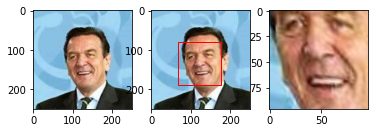

In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches


%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]

alignment = AlignDlib('models/landmarks.dat')

jc_orig = load_image(metadata[51].image_path())

bb = alignment.getLargestFaceBoundingBox(jc_orig)

jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

plt.subplot(131)
plt.imshow(jc_orig)

plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

plt.subplot(133)
plt.imshow(jc_aligned);

In [ ]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [ ]:
embedded = np.zeros((metadata.shape[0], 128))

for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    img = align_image(img)
    img = (img / 255.).astype(np.float32)
    embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, accuracy_score

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

X_train = embedded[train_idx]
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))
print(f'KNN accuracy = {acc_knn}')
print(f'SVM accuracy = {acc_svc}')

KNN accuracy = 0.9607843137254902
SVM accuracy = 0.9803921568627451


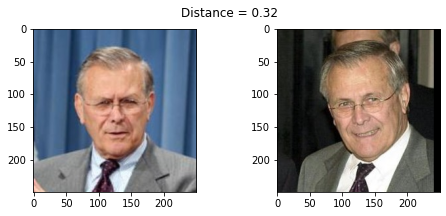

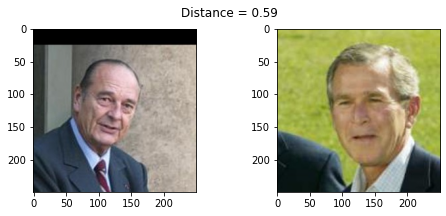

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(36, 38)
show_pair(77, 50)


0.3909249563699826


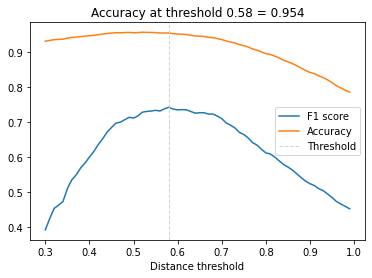

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] 
identical = [] 

num = len(metadata)

for i in range(num - 1):
    for j in range(i + 1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]
print(f1_scores[0])


opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

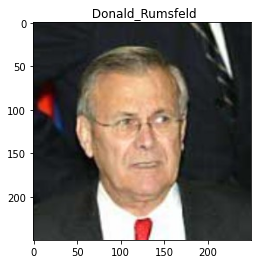

In [ ]:
import warnings
warnings.filterwarnings('ignore')

distanceInputFromDB =[]
example_idx = 16

for j in embedded:
  distanceInputFromDB.append(distance(embedded[test_idx][example_idx], j))

  if np.mean(distanceInputFromDB) < 2.5:
    example_image = load_image(metadata[test_idx][example_idx].image_path())
    example_prediction = svc.predict([embedded[test_idx][example_idx]])
    example_identity = encoder.inverse_transform(example_prediction)[0]

    plt.imshow(example_image)
    plt.title(f' {example_identity}');

  else:
    plt.imshow(example_image)
    plt.title('Unknown person');

In [ ]:
import firebase_admin
from firebase_admin import credentials, firestore
import google.cloud

cred = credentials.Certificate('/content/gdrive/My Drive/Face_Recognition2/home-automation.json')
firebase_admin.initialize_app(cred)

store = firestore.client()

doc_ref = store.collection(u'notification')
doc_ref.document("door").update({u'name': example_identity})


update_time {
  seconds: 1602074637
  nanos: 372223000
}